# Step 2: Data Wrangling
In this notebook, the data from all 3 tables are read in and an initial cleaning process is done to fill empty values, discard of unnecessary features and choosing relevant identifiers and features. Ultimately, only the material flow and error message tables are used and merged to a new table.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import math
%matplotlib inline

## Load data from SQL file

### Inspect database

In [175]:
con = sqlite3.connect('../data/data2.db')
cursor = con.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())

[('data',), ('error',), ('extra',)]


### Function(s) needed for analysis

In [2]:
def empty_features(df,threshold=0.9):
    # defines string containing feature names for features that are 90% or more empty or contain only one value (without being empty)
    str_empty = []
    for var in df.columns:
        if (sum(df[var].isna()) >=  (threshold*len(df[var]))) | (sum(df[var]==0) >=  (0.9*len(df[var]))) | ((len(df[var].unique())==1)&(sum(df[var].isna())==0)):
            str_empty.append(var)  
    return str_empty;

## Load MF (material flow) data

In [3]:
df_mf = pd.read_sql('SELECT * FROM data','sqlite:///../data/data2.db',index_col='index')
df_mf.head()

,id_000,ty_000,cl_000,xx_000,id_001,xx_001,cl_001,id_002,id_003,id_004,...,xx_024,xx_025,xx_026,flg_004,dt_001,xx_027,xx_028,xx_029,ty_006,id_033
index,,,,,,,,,,,,,,,,,,,,,
0,372892,ty_000_007,cl_000_001,5,None,xx_001_000,cl_001_001,1.0,None,None,...,0,0,64,0,2020-04-09 06:01:09,xx_027_002,0,xx_029_000,ty_006_000,1041973
1,372893,ty_000_010,cl_000_000,5,None,xx_001_000,cl_001_000,1.0,None,None,...,0,0,41,0,2020-04-09 06:01:39,xx_027_001,0,xx_029_000,ty_006_000,1041974
2,372894,ty_000_010,cl_000_000,5,None,xx_001_000,cl_001_000,2.0,None,None,...,0,0,44,0,2020-04-09 06:01:39,xx_027_001,0,xx_029_000,ty_006_000,1041975
3,372893,ty_000_010,cl_000_000,20,None,xx_001_000,cl_001_000,1.0,None,None,...,0,0,50,0,2020-04-09 06:01:39,xx_027_001,2,xx_029_001,ty_006_001,1041976
4,372894,ty_000_010,cl_000_000,20,None,xx_001_000,cl_001_000,2.0,None,None,...,0,0,53,0,2020-04-09 06:01:39,xx_027_001,2,xx_029_001,ty_006_001,1041977


In [4]:
df_mf.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38432 entries, 0 to 38431
Data columns (total 87 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id_000   38432 non-null  int64  
 1   ty_000   38432 non-null  object 
 2   cl_000   38432 non-null  object 
 3   xx_000   38432 non-null  int64  
 4   id_001   36728 non-null  object 
 5   xx_001   27443 non-null  object 
 6   cl_001   26249 non-null  object 
 7   id_002   26210 non-null  float64
 8   id_003   34015 non-null  object 
 9   id_004   34015 non-null  object 
 10  id_005   22620 non-null  object 
 11  id_006   22620 non-null  object 
 12  id_007   20080 non-null  object 
 13  id_008   13437 non-null  object 
 14  id_009   132 non-null    object 
 15  id_010   132 non-null    object 
 16  id_011   2389 non-null   object 
 17  id_012   2389 non-null   object 
 18  xx_002   38432 non-null  int64  
 19  xx_003   38432 non-null  int64  
 20  ty_001   38432 non-null  int64  
 21  xx_004   261

In [5]:
str_empty = empty_features(df_mf)
print(np.sort(str_empty))
print(len(str_empty))

['cl_002' 'cl_004' 'dt_000' 'flg_000' 'flg_002' 'flg_003' 'flg_004'
 'id_009' 'id_010' 'id_011' 'id_012' 'id_013' 'id_014' 'id_015' 'id_016'
 'id_017' 'id_020' 'id_021' 'id_022' 'id_023' 'id_025' 'id_027' 'id_028'
 'id_029' 'id_030' 'id_031' 'id_032' 'ty_001' 'ty_003' 'ty_005' 'xx_002'
 'xx_003' 'xx_004' 'xx_006' 'xx_007' 'xx_008' 'xx_009' 'xx_010' 'xx_011'
 'xx_012' 'xx_013' 'xx_015' 'xx_017' 'xx_018' 'xx_019' 'xx_020' 'xx_021'
 'xx_022' 'xx_023' 'xx_024' 'xx_025']
51


Before we drop these features, let's first check whether the *extra* table has more information on some of these.

In [6]:
df_ex = pd.read_sql('SELECT * FROM extra','sqlite:///../data/data2.db',index_col='index')

First see if there are overlapping features

In [8]:
sql_str = ''
for var in str_empty:
    if var in df_ex.columns:
        if df_ex[var].count() > 10:
            print(var, ' ::: ',(df_ex[var].count()))
            sql_str = sql_str+'ex.'+var+', '

id_013  :::  154919
id_014  :::  224483
xx_006  :::  224483
id_016  :::  224483
xx_008  :::  22265
ty_005  :::  63871
cl_002  :::  224483
cl_004  :::  65008
id_020  :::  130964
id_027  :::  96322
flg_000  :::  224483
id_031  :::  224483
flg_004  :::  224483


In [9]:
# Turn dt into datetime and drop microseconds to compare
x = 'dt_001'
df_ex[x] = pd.to_datetime(df_ex[x])
#df_ex.loc[:,x] = df_ex[x].apply(lambda y: y.replace(microsecond=0))

df_mf[x] = pd.to_datetime(df_mf[x])
#df_mf.loc[:,x] = df_mf[x].apply(lambda y: y.replace(microsecond=0))

Identify common features to merge the two tables:

In [10]:
n_ex = len(df_ex.index)
n_mf = len(df_mf.index)
for v in df_mf.columns:
    if v in df_ex.columns:
        uni_mf = round(df_mf[v].nunique()/n_mf*100,1)
        both = 0
        df_red = df_ex[v].unique()
        for i in df_mf[v].unique():
            if i in df_red:
                both += 1
        uni_ex = round(both/n_mf*100,1)
        if uni_ex > 0:
            print('{} in data {}% are unique and {}% same as extra'.format(v,uni_mf,uni_ex))

id_001 in data 7.4% are unique and 6.3% same as extra
id_007 in data 0.1% are unique and 0.1% same as extra
id_014 in data 3.8% are unique and 3.4% same as extra
xx_006 in data 0.1% are unique and 0.1% same as extra
id_016 in data 0.5% are unique and 0.5% same as extra
id_026 in data 6.7% are unique and 1.3% same as extra
id_027 in data 0.5% are unique and 0.5% same as extra
xx_026 in data 35.1% are unique and 0.1% same as extra
dt_001 in data 27.8% are unique and 11.2% same as extra


## Load from data replacing missing values from extra table

In [11]:
sql_da = ''
for var in df_mf.drop(str_empty,axis=1).columns:
    sql_da += 'da.'+var+', '

In [56]:
df_temp= pd.read_sql('SELECT {}, {} FROM  data as da LEFT JOIN extra as ex on datetime(ex.dt_001)=datetime(da.dt_001) AND (ex.id_001 == da.id_001)'.format(sql_str[:-2],sql_da[:-2]),'sqlite:///../data/data2.db')
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39063 entries, 0 to 39062
Data columns (total 49 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id_013   4431 non-null   object 
 1   id_014   7668 non-null   float64
 2   xx_006   7668 non-null   float64
 3   id_016   7668 non-null   float64
 4   xx_008   241 non-null    object 
 5   ty_005   3765 non-null   object 
 6   cl_002   7668 non-null   object 
 7   cl_004   6141 non-null   object 
 8   id_020   3899 non-null   object 
 9   id_027   2510 non-null   object 
 10  flg_000  7668 non-null   float64
 11  id_031   7668 non-null   float64
 12  flg_004  7668 non-null   float64
 13  id_000   39063 non-null  int64  
 14  ty_000   39063 non-null  object 
 15  cl_000   39063 non-null  object 
 16  xx_000   39063 non-null  int64  
 17  id_001   37359 non-null  object 
 18  xx_001   28074 non-null  object 
 19  cl_001   26876 non-null  object 
 20  id_002   26819 non-null  float64
 21  id_003   346

#### Turn datetime strings into datetime objects

In [57]:
x = 'dt_001'
df_temp[x] = pd.to_datetime(df_temp[x])

Drop the empty features in the original data frame and the empty features of the extra data frame. Then merge these to data frames to the new data set on **dt_001**.

In [58]:
str_empty2 = empty_features(df_temp)
print(np.sort(str_empty2))
df_temp.drop(str_empty2,inplace=True,axis=1)

['id_020' 'id_027' 'ty_005' 'xx_008']


### This will be the table that will be used for further analysis, therefore we will investigate a bit further.

In [59]:
df_clean = df_temp
df_clean.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id_014,7668.0,3.811269e+04,32774.403459,0.0,0.0,58705.0,67776.0,73188.0
xx_006,7668.0,2.264476e+00,4.712853,0.0,0.0,0.0,2.0,40.0
id_016,7668.0,4.930700e+03,6997.545481,0.0,0.0,0.0,11075.0,25229.0
flg_000,7668.0,2.660407e-02,0.160934,0.0,0.0,0.0,0.0,1.0
id_031,7668.0,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.0
flg_004,7668.0,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.0
id_000,39063.0,3.841488e+05,6268.187852,372528.0,377061.0,385230.0,389389.0,393571.0
xx_000,39063.0,1.861127e+01,19.353513,5.0,5.0,10.0,20.0,99.0
id_002,26819.0,1.017749e+00,0.132039,1.0,1.0,1.0,1.0,2.0
xx_005,39063.0,1.243709e+00,2.173612,-2.0,0.0,0.0,2.0,6.0


Of the above we already know that all **id** and the **flg** features are actually objects. Let's take an even closer look:

In [60]:
df_clean.drop(['id_031','flg_004'],axis=1,inplace=True)

for var in df_clean.columns:
    uni = df_clean[var].unique()
    if None == df_clean[var].unique()[0]:
        uni = uni[1:]
    if (len(uni)>20):
        continue
    if isinstance(uni[0],str)== False:
        print(var,' ::: ',uni)
    elif ('_' not in uni[0]):
        print(var,' ::: ',uni)

flg_000  :::  [nan  0.  1.]
xx_000  :::  [ 5 20 60 99 10 40]
id_002  :::  [ 1.  2. nan]
xx_005  :::  [ 0  5  1 -2 -1  3  6  2]
cl_003  :::  ['2' '3' '1' '6' '4' '5']
cl_005  :::  ['2' '999' '1']
xx_014  :::  ['00']
cl_006  :::  ['1' '0']
cl_007  :::  ['2' '3' '1' '0']
cl_008  :::  ['1' '0']
id_024  :::  ['1' '0']
flg_001  :::  [0 1]


To keep the logic of the labeling within the data set, we will rename categories that are clearly classes, flags or identifiers.

In [61]:
for var in ['xx_000','xx_014','id_002','id_024','cl_003','cl_005','cl_006','cl_007','cl_008','flg_001','flg_000']:
    uni = df_clean[var].unique()
    for v in uni:
        if isinstance(v,str):
            if v == '999':
                df_clean.loc[df_clean[var]==v,var] = np.NaN
                continue
        elif v == None:
            continue
        elif np.isnan(v):
            continue
        df_clean.loc[df_clean[var]==v,var] = '{}_{:01d}'.format(var,int(v))

In [62]:
for var in ['xx_000','xx_014','id_000','id_002','id_024','id_026','id_033','cl_003','cl_005','cl_006','cl_007','cl_008','flg_001']:
    df_clean.loc[:,var] = df_clean[var].astype(object)

### Analyze the ratio of missing values and unique values

In [63]:
df_analysis = pd.DataFrame(df_clean.nunique(),columns=['nunique'])
df_analysis['ratio_unique'] = np.round(df_clean.nunique()/df_clean.count()*100,1)
df_analysis['ratio_filled'] = np.round(df_clean.count()/len(df_clean.index)*100,1)
df_analysis

,nunique,ratio_unique,ratio_filled
id_013,204,4.6,11.3
id_014,205,2.7,19.6
xx_006,26,0.3,19.6
id_016,258,3.4,19.6
cl_002,1,0.0,19.6
cl_004,5,0.1,15.7
flg_000,2,0.0,19.6
id_000,16651,42.6,100.0
ty_000,17,0.0,100.0
cl_000,2,0.0,100.0


This teaches us that only **id_033** has unique values and that there are some id's that could be dropped since they are neither unique nore few enough to categorize into larger groups. This is something that will be addressed with the cummulative frequency method below.

Further, **xx_000**, **xx_001**, **xx_005**, **xx_014**, **xx_027** and **xx_029** are most likely categorical features. Potentially **xx_028** too. This as well as **xx_016** and **xx_026** need to be investigated in detail though.

Replacing *999* in **cl_005** with *nan* lead to the feature to be almost empty. It can be dropped:

In [64]:
df_clean.drop('cl_005',axis=1,inplace=True)

### Investigating xx_006
This is the only **xx** that has missing values AND is not categorical.

/home/lhw/DSproject/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/lhw/DSproject/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


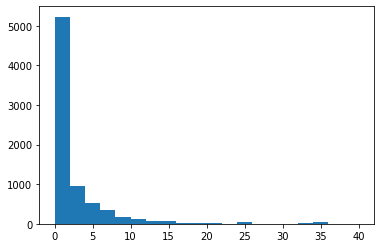

In [65]:
plt.hist(df_clean.xx_006,bins=20)
plt.show()

In [68]:
df_clean['xx_006'].fillna(999,inplace = True)

### Fill missing categorical values
Since the few remaining undefined features have no missing values, we can simply fill all missing values with *unknown*.

In [74]:
for var in df_clean.columns:
    df_clean[var].fillna(var+'_unknown',inplace=True)

In [75]:
df_clean = df_clean.drop_duplicates()

## Reduce the number of categories

### Make exemplary Cummulative Frequency Curve plot

In [23]:
def cfc(data): 
    # Cumulative frequency curve
    data = -1* np.sort(-data)
    total = sum(data)
    y = [data[0]] 
    for yi in data[1:]:
        y.append(yi+y[-1])
    y = y/total
    x = np.arange(1,len(data)+1)/len(data)
    return x,y;

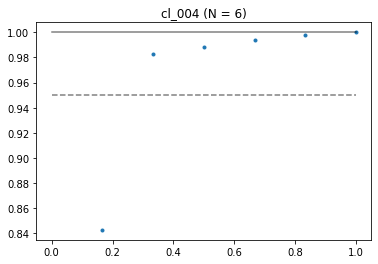

In [76]:
var = 'cl_004'
counts = df_clean[var].value_counts()
x, y = cfc(counts)
plt.plot(x,y,'.')
#mu = np.mean(counts)
#sigma = np.std(counts)
#samples = np.random.normal(mu,sigma,size=10000)
#x_theor, y_theor = cfc(samples)
#plt.plot(x_theor,y_theor)
plt.plot([0,1],[0.95,0.95],'k--',alpha=0.5)
plt.plot([0,1],[1,1],'k',alpha=0.5)
plt.title('{} (N = {})'.format(var,len(counts)))
plt.show()
#print(np.round(mu,2),np.round(sigma,2))

The example above shows, that it takes only 2 out of 6 categories to represent over 95% of the data set. Furthermore, there is 1 category that represents almost 85% of the data.

Below we analyze categorical features for their potential to reduce the number of categories by replacing categories which contribute only to the final 5% of the cumulative frequency. Dummies for the remaining categories are created.

In [77]:
df_reduced = df_clean.copy()
for var in df_clean.columns:   #['client']:# 
    if type(df_clean[var][0]) != str:
        print(var, ' is not a string')
        continue
    counts = df_clean[var].value_counts()
    x,y = cfc(counts)
    if len(counts) == 1:
        print('{} has only one category, namely {}.'.format(var,counts.index[0]))
        df_reduced.drop(var,axis=1,inplace=True)
    elif len(counts) == 2:
        if (1 in counts.index) & (0 in counts.index):
            print('{} remains {} and {}.'.format(var,counts.index[0],counts.index[1]))
            continue
        elif ('1' in counts.index) & ('0' in counts.index):
            df_reduced.loc[:,var] = df_reduced[var].astype(int)
        print('{} has only two categories, namely {} and {}.'.format(var,counts.index[0],counts.index[1]))
    elif len(counts) == len(df_clean[var]):
        print('{} has only unique values.'.format(var))    
    elif min(y) > 0.95:
        df_reduced.loc[df_reduced[var].isin(counts.index[1:]),var] = var +'_other'
    else:
        ind = np.max(np.where(y <= 0.95)[0])
        if (ind <= 0.75 * len(counts.index)) & (ind < 10):
            df_reduced.loc[df_reduced[var].isin(counts.index[ind+1:]),var] = var +'_other'
            print('For {} {} entries were reduced.'.format(var,sum(df_reduced[var]==var +'_other')))
        else:
            print('{} does not have enough dominant features.'.format(var))

id_013 does not have enough dominant features.
id_014 does not have enough dominant features.
xx_006  is not a string
id_016 does not have enough dominant features.
cl_002 has only two categories, namely cl_002_unknown and cl_002_000.
For cl_004 6138 entries were reduced.
For flg_000 7652 entries were reduced.
id_000  is not a string
For ty_000 4042 entries were reduced.
cl_000 has only two categories, namely cl_000_000 and cl_000_001.
For xx_000 5879 entries were reduced.
id_001 does not have enough dominant features.
xx_001 has only two categories, namely xx_001_000 and xx_001_unknown.
For cl_001 8486 entries were reduced.
For id_002 12717 entries were reduced.
For id_003 2399 entries were reduced.
id_004 does not have enough dominant features.
For id_005 2403 entries were reduced.
id_006 does not have enough dominant features.
For id_007 1977 entries were reduced.
id_008 does not have enough dominant features.
xx_005  is not a string
For ty_002 2274 entries were reduced.
ty_004 has 

### Inspect integer features of type 'xx' 

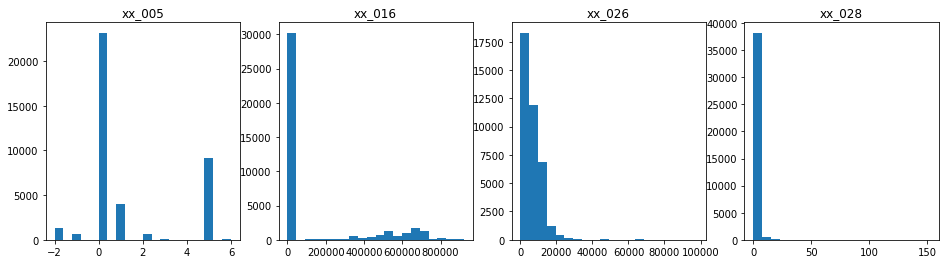

In [78]:
k = 1
plt.figure(figsize=(16,4))
for v in ['xx_005','xx_016','xx_026','xx_028']:
    plt.subplot(1,4,k)
    plt.hist(df_reduced[v],bins=20)
    plt.title(v)
    k+=1
plt.show()

**xx_005** is actually ordinal data, **xx_016** has very distinct values which indicates that it might be a measure with '0' representing missing values, and based on inside knowledge it can be said that **xx_026** is an identifier and **xx_028** is a measure.

We therefore turn the categorical feature into real categories:

In [79]:
for var in ['xx_005']: # 'xx_000',
    vals = df_reduced[var].value_counts().index
    k = 0
    for v in vals:
        df_reduced.loc[df_reduced[var].values==v,var]= '{}_{:02d}'.format(var,v)
        k+=1
    counts = df_reduced[var].value_counts()
    x,y = cfc(counts)
    ind = np.max(np.where(y <= 0.95)[0])
    if (ind <= 0.75 * len(counts.index)) & (ind < 10):
        df_reduced.loc[df_reduced[var].isin(counts.index[ind+1:]),var] = var +'_other'
        print('For {} {} entries were reduced.'.format(var,sum(df_reduced[var]==var +'_other')))

For xx_005 2718 entries were reduced.


### One final look at the dominant categories per feature 

In [80]:
df_analysis = pd.DataFrame(df_reduced.nunique(),columns=['nunique'])
no1 = []
no1_cnt = []
no2 = []
no2_cnt = []
for v in df_reduced.columns:
    no1.append(df_reduced.loc[:,v].value_counts().index[0])
    no1_cnt.append(df_reduced.loc[:,v].value_counts().iloc[0])
    no2.append(df_reduced.loc[:,v].value_counts().index[1])
    no2_cnt.append(df_reduced.loc[:,v].value_counts().iloc[1])
nvals = len(df_reduced.iloc[:,0])
df_analysis['no1'] = no1
df_analysis['# no1'] = no1_cnt
df_analysis['% no1'] = np.round(np.array(no1_cnt)/nvals*100,1)
df_analysis['no2'] = no2
df_analysis['# no2'] = no2_cnt
df_analysis['% no2'] = np.round(np.array(no2_cnt)/nvals*100,1)

df_analysis

,nunique,no1,# no1,% no1,no2,# no2,% no2
id_013,205,id_013_unknown,34632,88.7,190050,136,0.3
id_014,206,id_014_unknown,31395,80.4,0,3237,8.3
xx_006,27,999,31395,80.4,0,3843,9.8
id_016,259,id_016_unknown,31395,80.4,0,3843,9.8
cl_002,2,cl_002_unknown,31395,80.4,cl_002_000,7652,19.6
cl_004,2,cl_004_unknown,32909,84.3,cl_004_other,6138,15.7
flg_000,2,flg_000_unknown,31395,80.4,flg_000_other,7652,19.6
id_000,16651,382961,6,0.0,381754,6,0.0
ty_000,7,ty_000_000,8370,21.4,ty_000_001,7824,20.0
cl_000,2,cl_000_000,28087,71.9,cl_000_001,10960,28.1


Now we have reduced the number of categories to the most relevant ones. Additionally, we see that many **id** features could be reduced to just a few, while others do not have dominant features and can likely be dropped. We will hold on to these until we have successfully merged with the error table, except for **id_014** and **id_016** since *unknown* and *0* are the same in this case, and therefor too dominant.

In [81]:
df_reduced.drop(['id_014','id_016'],axis=1,inplace=True)

### Save to csv

In [82]:
con = sqlite3.connect('../data/data2.db')
df_reduced.to_sql(name='data_clean',con=con,if_exists='replace')
con.close()

## Load error message table

In [31]:
df_err = pd.read_sql('SELECT * FROM error','sqlite:///../data/data2.db',index_col='index')

In [32]:
str_empty = empty_features(df_err)
df_err.drop(str_empty,inplace=True,axis=1)
df_err.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14039 entries, 0 to 14038
Data columns (total 25 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id_033   14039 non-null  int64  
 1   id_034   14039 non-null  int64  
 2   xx_030   14039 non-null  object 
 3   ty_007   14039 non-null  object 
 4   ty_008   14039 non-null  object 
 5   id_021   14039 non-null  int64  
 6   id_035   6626 non-null   object 
 7   id_036   6338 non-null   object 
 8   id_037   6624 non-null   object 
 9   id_001   6725 non-null   object 
 10  id_039   4201 non-null   float64
 11  xx_001   3333 non-null   object 
 12  cl_001   3333 non-null   object 
 13  id_002   3333 non-null   float64
 14  xx_034   8628 non-null   object 
 15  xx_035   4892 non-null   object 
 16  cl_009   6534 non-null   object 
 17  dt_014   13466 non-null  object 
 18  dt_015   11398 non-null  object 
 19  dt_016   14039 non-null  int64  
 20  xx_026   14039 non-null  int64  
 21  flg_004  140

In [33]:
df_analysis = pd.DataFrame(df_err.nunique(),columns=['nunique'])
df_analysis['ratio_unique'] = np.round(df_err.nunique()/df_err.count()*100,1)
df_analysis['ratio_filled'] = np.round(df_err.count()/len(df_err.index)*100,1)
df_analysis

,nunique,ratio_unique,ratio_filled
id_033,14039,100.0,100.0
id_034,13875,98.8,100.0
xx_030,6,0.0,100.0
ty_007,10,0.1,100.0
ty_008,5,0.0,100.0
id_021,116,0.8,100.0
id_035,2,0.0,47.2
id_036,12,0.2,45.1
id_037,206,3.1,47.2
id_001,2660,39.6,47.9


### Turn datetime string into datetime objects

In [34]:
x = 'dt_001'
df_err[x] = pd.to_datetime(df_err[x])

### Identify features that the mfque and the error table have in common

In [36]:
n_err = len(df_err.index)
n_mfq = len(df_reduced.index)
for v in df_err.columns:
    if v in df_reduced.columns:
        uni_err = round(df_err[v].nunique()/n_err*100,1)
        both = 0
        df_red = df_reduced[v].unique()
        for i in df_err[v].unique():
            if i in df_red:
                both += 1
        uni_mfq = round(both/n_err*100,1)
        if uni_mfq >0 :
            print('{} in error {}% are unique and {}% same as mfq'.format(v,uni_err,uni_mfq))

id_001 in error 18.9% are unique and 2.6% same as mfq
xx_026 in error 52.4% are unique and 40.7% same as mfq
dt_001 in error 75.4% are unique and 4.1% same as mfq


There are overlapping features for **id_001**, **xx_026**, and **dt_001**. A combination of these features will be needed to merge the mfque table with the error table.

In [37]:
print('Error table starts on: {} and ends on {}'.format(df_err.dt_001.iloc[0],df_err.dt_001.iloc[-1]))
print('Error table starts on: {} and ends on {}'.format(df_reduced.dt_001.iloc[0],df_reduced.dt_001.iloc[-1]))

Error table starts on: 2019-03-18 07:41:53 and ends on 2020-04-24 13:58:06
Error table starts on: 2020-04-09 06:01:09 and ends on 2020-04-27 14:55:09


Here we see one reason for the small overlap: The timespan of the error table is much wider than the timespan of the mfq table.

### Save to csv

In [38]:
con = sqlite3.connect('../data/data2.db')
df_err.to_sql(name='error_clean',con=con,if_exists='replace')
con.close()

# Join material flow table with error messages

In [83]:
df_combo= pd.read_sql('SELECT da.*, err.id_034 as error FROM data_clean as da LEFT JOIN error_clean as err on datetime(err.dt_001)=datetime(da.dt_001) AND (err.id_001 == da.id_001)','sqlite:///../data/data2.db')
df_combo.drop('index',axis=1,inplace=True)
df_combo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39169 entries, 0 to 39168
Data columns (total 41 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id_013   39169 non-null  object 
 1   xx_006   39169 non-null  float64
 2   cl_002   39169 non-null  object 
 3   cl_004   39169 non-null  object 
 4   flg_000  39169 non-null  object 
 5   id_000   39169 non-null  int64  
 6   ty_000   39169 non-null  object 
 7   cl_000   39169 non-null  object 
 8   xx_000   39169 non-null  object 
 9   id_001   39169 non-null  object 
 10  xx_001   39169 non-null  object 
 11  cl_001   39169 non-null  object 
 12  id_002   39169 non-null  object 
 13  id_003   39169 non-null  object 
 14  id_004   39169 non-null  object 
 15  id_005   39169 non-null  object 
 16  id_006   39169 non-null  object 
 17  id_007   39169 non-null  object 
 18  id_008   39169 non-null  object 
 19  xx_005   39169 non-null  object 
 20  ty_002   39169 non-null  object 
 21  ty_004   391

We see that we have 2008 non-zero errors among the 39169 jobs. Feature **id_034** is now labeled as **error** and is chosen to represent the jobs with errors and will be masked as 0 (no error) and 1 (error) below. It was just important to choose a 100% filled feature from the error table that is not contained in the mfque table.

In [84]:
df_combo.loc[:,'error'] = df_combo['error'].apply(lambda x: 0 if math.isnan(x) else 1)

Let's also make sure that we do not have duplicate rows.

In [85]:
df_combo.drop_duplicates(inplace= True)

The **flg_001** feature contains only 0 and 1, therefore it is an integer. But some **id** features are again stored as int. Turn them into objects:

In [86]:
var = ['id_000','id_033']
df_combo.loc[:,var] = df_combo[var].astype(object)
df_combo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39047 entries, 0 to 39168
Data columns (total 41 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id_013   39047 non-null  object 
 1   xx_006   39047 non-null  float64
 2   cl_002   39047 non-null  object 
 3   cl_004   39047 non-null  object 
 4   flg_000  39047 non-null  object 
 5   id_000   39047 non-null  object 
 6   ty_000   39047 non-null  object 
 7   cl_000   39047 non-null  object 
 8   xx_000   39047 non-null  object 
 9   id_001   39047 non-null  object 
 10  xx_001   39047 non-null  object 
 11  cl_001   39047 non-null  object 
 12  id_002   39047 non-null  object 
 13  id_003   39047 non-null  object 
 14  id_004   39047 non-null  object 
 15  id_005   39047 non-null  object 
 16  id_006   39047 non-null  object 
 17  id_007   39047 non-null  object 
 18  id_008   39047 non-null  object 
 19  xx_005   39047 non-null  object 
 20  ty_002   39047 non-null  object 
 21  ty_004   390

For now, the other features remain as they are and will be dealt with in the Exploratory Data Analysis section.

## Save to SQL file

In [87]:
con = sqlite3.connect('../data/data2.db')
df_combo.to_sql(name='data_error',con=con,if_exists='replace')
con.close()